In [1]:
# Import necessary modules
import networkx as nx
from nxviz import MatrixPlot, ArcPlot, CircosPlot
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
from data.data2 import edges, nodes

In [2]:
G = nx.Graph()
G.add_edges_from(edges)
G.add_nodes_from(nodes)

### The bipartite keyword

Let's introduce the the ```'bipartite'``` keyword. This keyword is part of a node's metadata dictionary, and can be assigned both when you add a node and after the node is added. Remember, though, that by definition, in a bipartite graph, a node cannot be connected to another node in the same partition.

In the next cell, we're going to write a function that returns the nodes from a given partition in a bipartite graph. In this case, the relevant partitions of the Github bipartite graph you'll be working with are ```'projects'``` and ```'users'```.

In [3]:
# Define get_nodes_from_partition()
def get_nodes_from_partition(G, partition):
    # Initialize an empty list for nodes to be returned
    nodes = []
    # Iterate over each node in the graph G
    for n in G.nodes():
        # Check that the node belongs to the particular partition
        if G.node[n]['bipartite'] == partition:
            # If so, append it to the list of nodes
            nodes.append(n)
    return nodes

# Print the number of nodes in the 'projects' partition
print(len(get_nodes_from_partition(G, 'projects')))
# Print the number of nodes in the 'users' partition
print(len(get_nodes_from_partition(G, 'users')))

11774
10677


### Degree centrality distribution of user nodes
In this cell and the next one, we're going to do a final recap of material from the previous course. Our task is to plot the degree centrality distributions for each node partition in the bipartite version of the GitHub collaboration network. Here, we'll do this for the ```'users'``` partition. In the next cell, we'll do this for the ```'projects'``` partition.

Just to refresh, the "degree centrality" is a measure of node importance, and the "degree centrality distribution" is the list of degree centrality scores for all nodes in the graph. A few cell ago, when you made the circos plot, we computed the degree centralities.

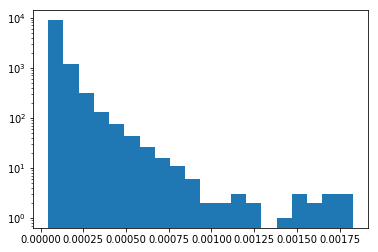

In [4]:
# Get the 'users' nodes: user_nodes
user_nodes = get_nodes_from_partition(G, 'users')

# Compute the degree centralities: dcs
dcs = nx.degree_centrality(G)

# Get the degree centralities for user_nodes: user_dcs
user_dcs = [dcs[n] for n in user_nodes]

# Plot the degree distribution of users_dcs
plt.yscale('log')
plt.hist(user_dcs, bins=20)
plt.show()


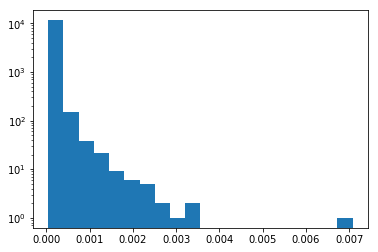

In [5]:
# Get the 'projects' nodes: user_nodes
user_nodes = get_nodes_from_partition(G, 'projects')

# Compute the degree centralities: dcs
dcs = nx.degree_centrality(G)

# Get the degree centralities for projects_nodes: projects_dcs
projects_dcs = [dcs[n] for n in user_nodes]

# Plot the degree distribution of projects_dcs
plt.yscale('log')
plt.hist(projects_dcs, bins=20)
plt.show()


### Shared nodes in other partition
In order to build up our concept of recommendation systems, we are going to start with the fundamentals. The focus here is on computing user similarity in bipartite graphs.

Our job is to write a function that takes in two nodes, and returns the set of repository nodes that are shared between the two user nodes.

We'll find the following methods and functions helpful in this exercise - ```.neighbors()```, ```set()```, and ```.intersection()``` - besides, of course, the ```shared_partition_nodes``` function that we will define!

In [6]:
def shared_partition_nodes(G, node1, node2):
    # Check that the nodes belong to the same partition
    assert G.node[node1]['bipartite'] == G.node[node2]['bipartite']

    # Get neighbors of node 1: nbrs1
    nbrs1 = G.neighbors(node1)
    # Get neighbors of node 2: nbrs2
    nbrs2 = G.neighbors(node2)

    # Compute the overlap using set intersections
    overlap = set(nbrs1).intersection(nbrs2)
    return overlap

# Print the number of shared repositories between users 'u7909' and 'u2148'
print(len(shared_partition_nodes(G, 'u7909', 'u2148')))


3


### User similarity metric
Having written a function to calculate the set of nodes that are shared between two nodes, you're now going to write a function to compute a <b>metric of similarity</b> between two users: the number of projects shared between two users divided by the total number of nodes in the other partition. This can then be used to find users that are similar to one another.

In [7]:
def user_similarity(G, user1, user2, proj_nodes):
    # Check that the nodes belong to the 'users' partition
    assert G.node[user1]['bipartite'] == 'users'
    assert G.node[user2]['bipartite'] == 'users'

    # Get the set of nodes shared between the two users
    shared_nodes = shared_partition_nodes(G, user1, user2)

    # Return the fraction of nodes in the projects partition
    return len(shared_nodes) / len(proj_nodes)

# Compute the similarity score between users 'u4560' and 'u1880'
project_nodes = get_nodes_from_partition(G, 'projects')
similarity_score = user_similarity(G, 'u4560', 'u1880', project_nodes)

print(similarity_score)


0.0


### Find similar users
We're now going to build upon what we've learned so far to write a function called most_similar_users() that finds the users most similar to another given user.

The list of nodes, ```project_nodes```contains all of the users except the given user that has been passed into the function. <br>
The list of nodes, ```project_nodes```contains all of the project except the given project that has been passed into the function. <br>
A dictionary called ```similarities``` contains the keys are the scores and the list of values are the nodes.

In [8]:
from collections import defaultdict

def most_similar_users(G, user, user_nodes, proj_nodes):
    # Data checks
    assert G.node[user]['bipartite'] == 'users'

    # Get other nodes from user partition
    user_nodes = set(user_nodes) 
    user_nodes.remove(user)

    # Create the dictionary: similarities
    similarities = defaultdict(list)
    for n in user_nodes:
        similarity = user_similarity(G, user, n, proj_nodes)
        similarities[similarity].append(n)

    # Compute maximum similarity score: max_similarity
    max_similarity = max(similarities.keys())

    # Return list of users that share maximal similarity
    return similarities[max_similarity]

user_nodes = get_nodes_from_partition(G, 'users')
project_nodes = get_nodes_from_partition(G, 'projects')
# Use  most_similar_users() function to print the list of users most similar to the user 'u4560'
print(most_similar_users(G, 'u4560', user_nodes, project_nodes))


['u14984', 'u1570', 'u2800', 'u9525', 'u53', 'u363']


### Recommend repositories
Now we will write a function called ```recommend_repositories()``` that accepts 3 arguments - ```G```, ```from_user```, and ```to_user``` - and returns the repositories that the ```from_user``` is connected to that the ```to_user``` is not connected to.

In [9]:
def recommend_repositories(G, from_user, to_user):
    # Get the set of repositories that from_user has contributed to
    from_repos = set(G.neighbors(from_user))
    # Get the set of repositories that to_user has contributed to
    to_repos = set(G.neighbors(to_user))

    # Identify repositories that the from_user is connected to that the to_user is not connected to
    return from_repos.difference(to_repos)

# Print the repositories to be recommended
print(recommend_repositories(G, 'u7909', 'u2148'))


{'p7408', 'p66', 'p32418', 'p9312'}
